## for GPU-accelerated ELM, install `scikit-cuda` package from Pip

In [3]:
# !pip install numpy==1.21 scikit-cuda hpelm

In [6]:
import hpelm

In [7]:
import numpy as np

In [8]:
from sklearn.datasets import make_moons, make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [9]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = [10, 8]

## Prepare some data

In [10]:
X, Y = make_moons(n_samples=2000000, noise=0.3)
Xt, Xs, Yt, Ys = train_test_split(X, Y, test_size=0.3)
subs = 1000  # subsampling for plots
L = 100  # number of non-linear neurons

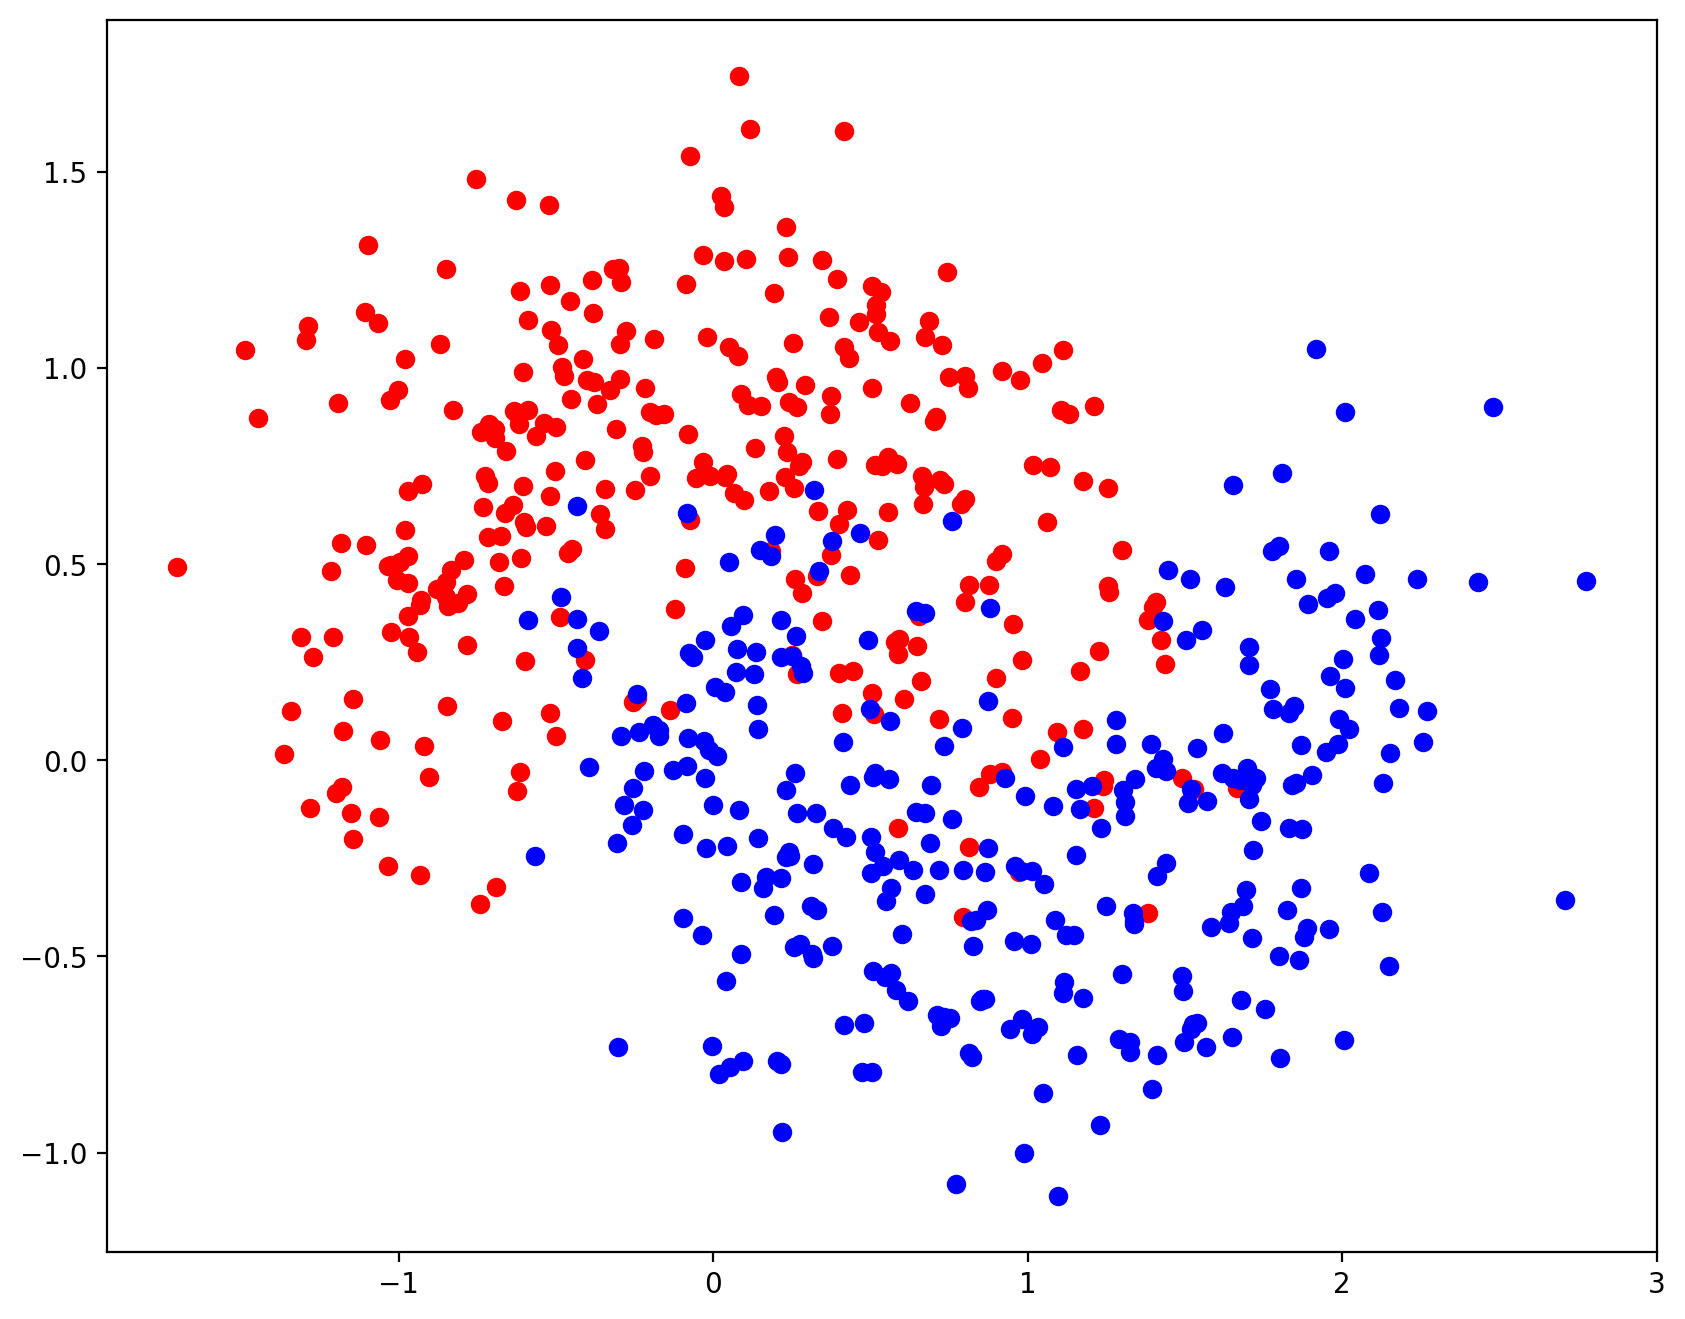

In [11]:
plt.scatter(Xs[Ys==0, 0][::subs], Xs[Ys==0, 1][::subs], c="r")
plt.scatter(Xs[Ys==1, 0][::subs], Xs[Ys==1, 1][::subs], c="b")
plt.show()

In [12]:
rfc = RandomForestClassifier(n_estimators=8, n_jobs=-1)
%time rfc.fit(Xt, Yt)
Yh = rfc.predict(Xs)

CPU times: user 27.7 s, sys: 365 ms, total: 28.1 s
Wall time: 4.99 s


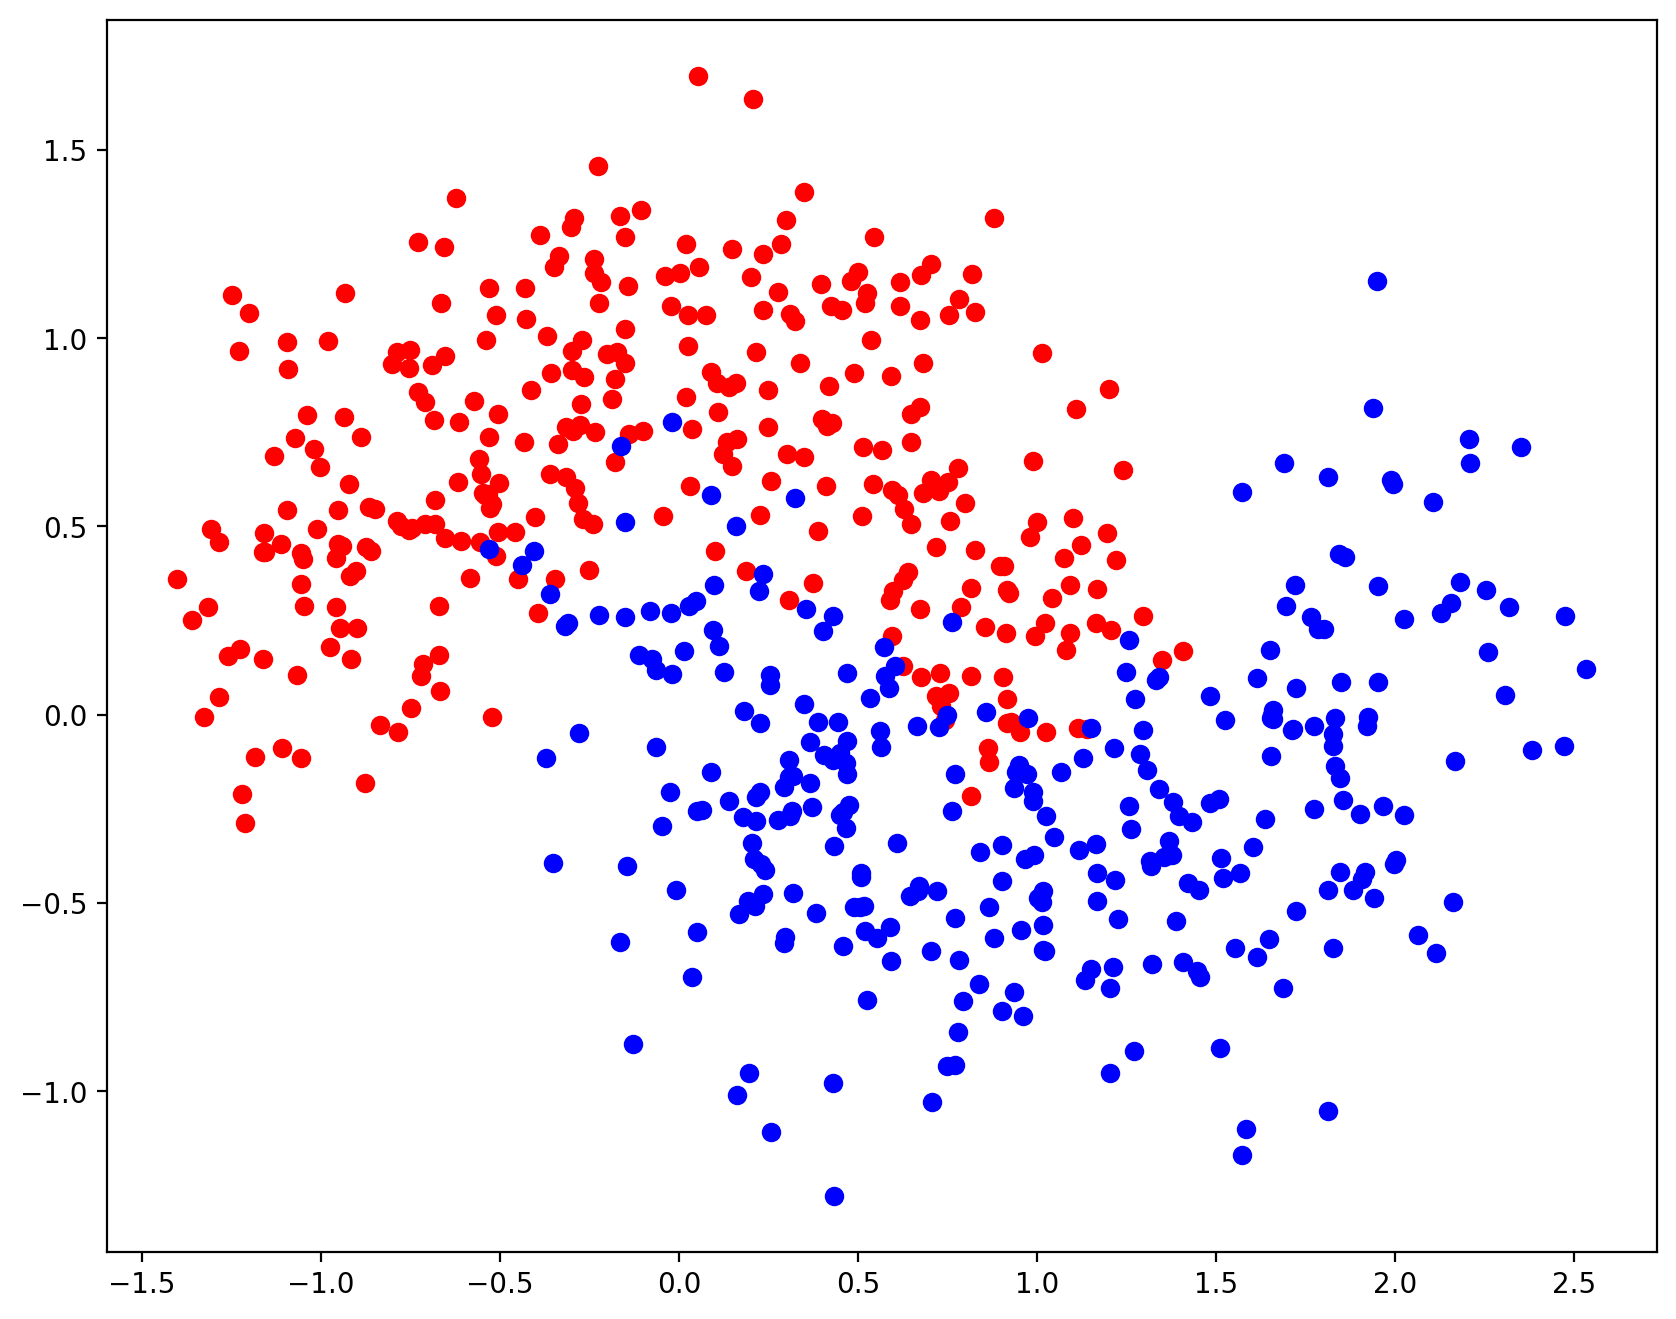

In [13]:
plt.scatter(Xs[Yh==0, 0][::subs], Xs[Yh==0, 1][::subs], c="r")
plt.scatter(Xs[Yh==1, 0][::subs], Xs[Yh==1, 1][::subs], c="b")
plt.show()

## Run HPELM

In [14]:
elm = hpelm.HPELM(2, 1, precision='double', norm=1)

In [15]:
elm.add_neurons(2, 'lin')
elm.add_neurons(L, 'tanh')

In [16]:
%time elm.train(Xt, Yt)

CPU times: user 1.01 s, sys: 13.6 ms, total: 1.03 s
Wall time: 1.03 s


In [17]:
Yh = elm.predict(Xs)

In [18]:
Yh = np.array(Yh[:,0] > 0.5, dtype=int)

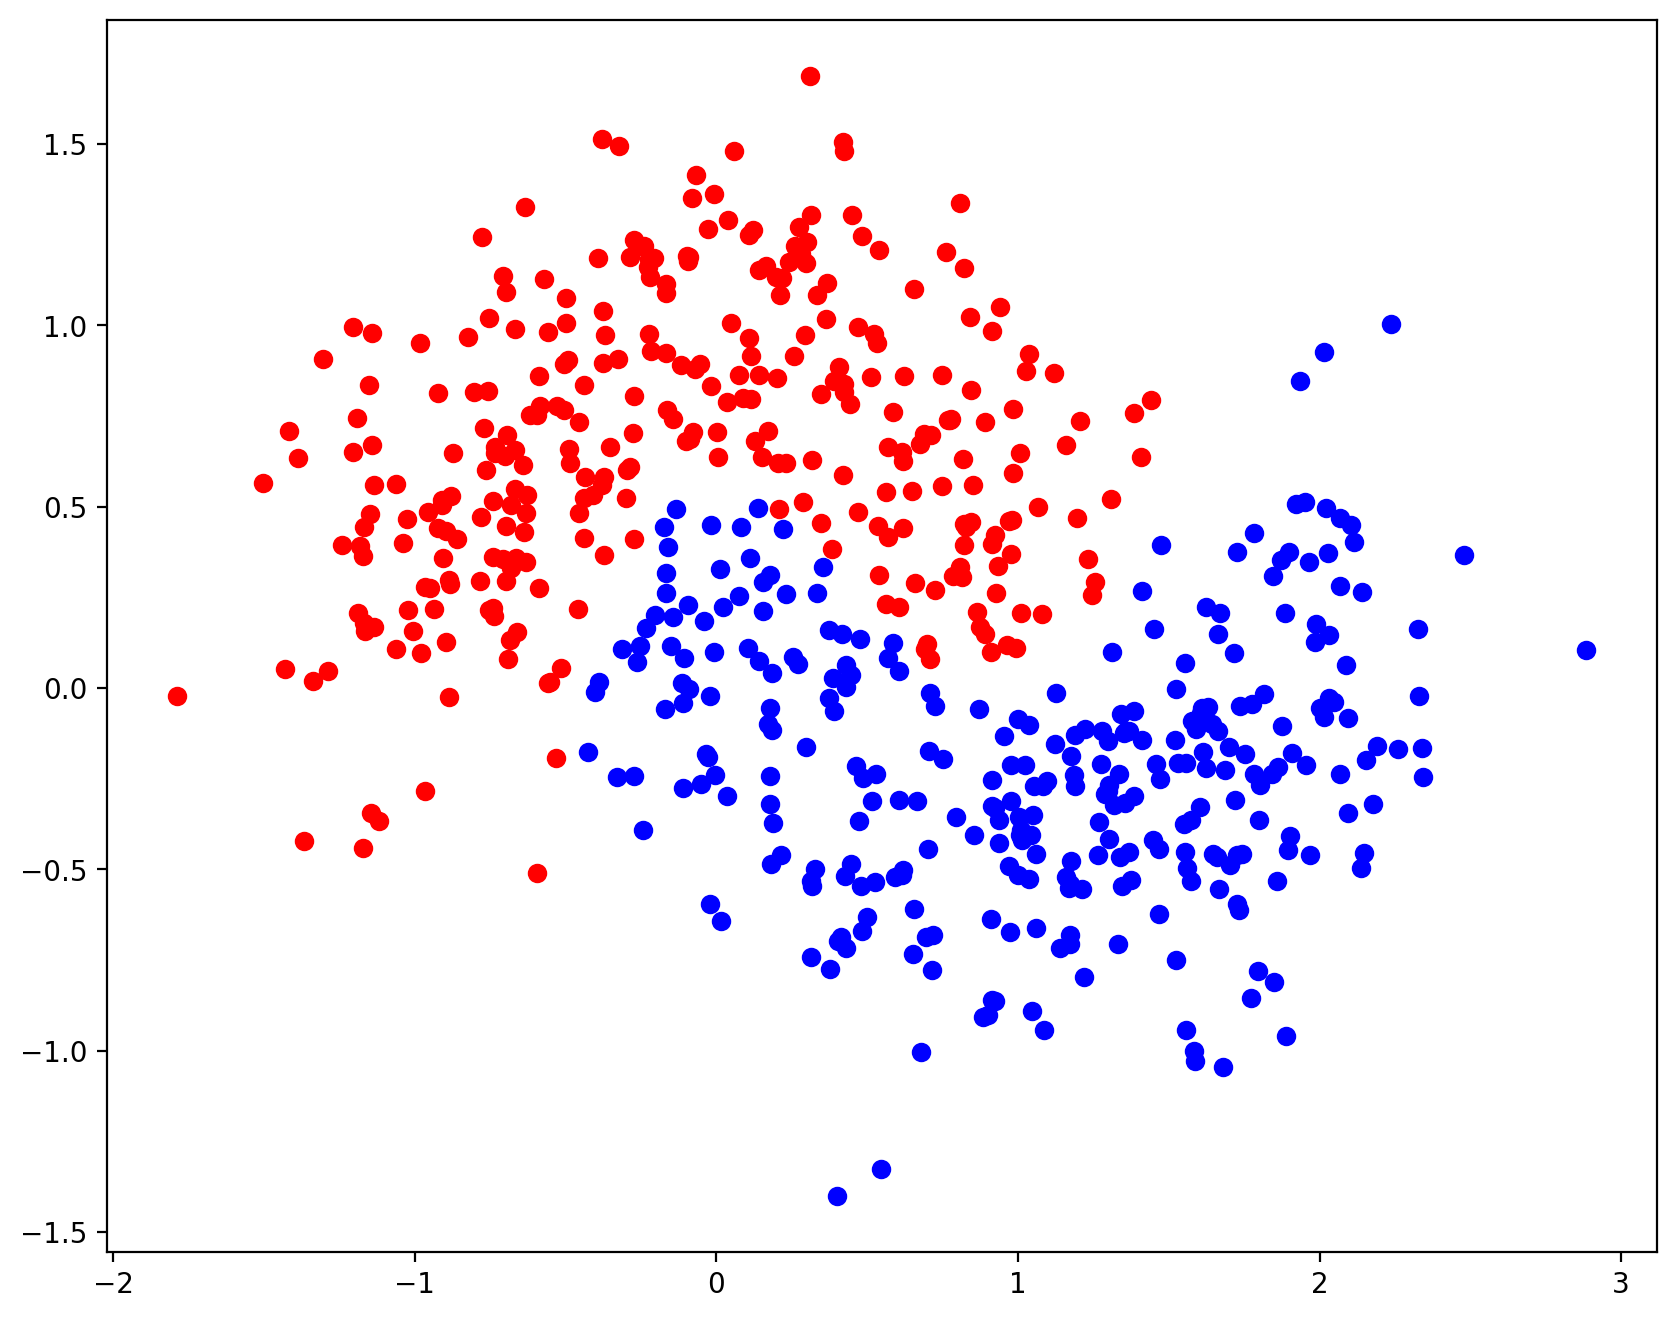

In [19]:
plt.scatter(Xs[Yh==0, 0][::subs], Xs[Yh==0, 1][::subs], c="r")
plt.scatter(Xs[Yh==1, 0][::subs], Xs[Yh==1, 1][::subs], c="b")
plt.show()

## Run HPELM+GPU

In [20]:
import os

In [21]:
# elm2 = hpelm.HPELM(2, 1, precision='single', accelerator="GPU", norm=1)
elm2 = hpelm.HPELM(2, 1, precision='single', norm=1)

In [22]:
elm2.add_neurons(2, 'lin')
elm2.add_neurons(L, 'tanh')

In [23]:
%time elm2.train(Xt, Yt)

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
CPU times: user 868 ms, sys: 6.51 ms, total: 874 ms
Wall time: 878 ms


/Users/akusok/.pyenv/versions/jupyter/lib/python3.11/site-packages/hpelm/nnets/slfn_python.py:65: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B = np.linalg.lstsq(HH, HT)[0]


In [24]:
Yh = elm2.predict(Xs)

In [26]:
Yh = np.array(Yh[:,0] > 0.5, dtype=int)

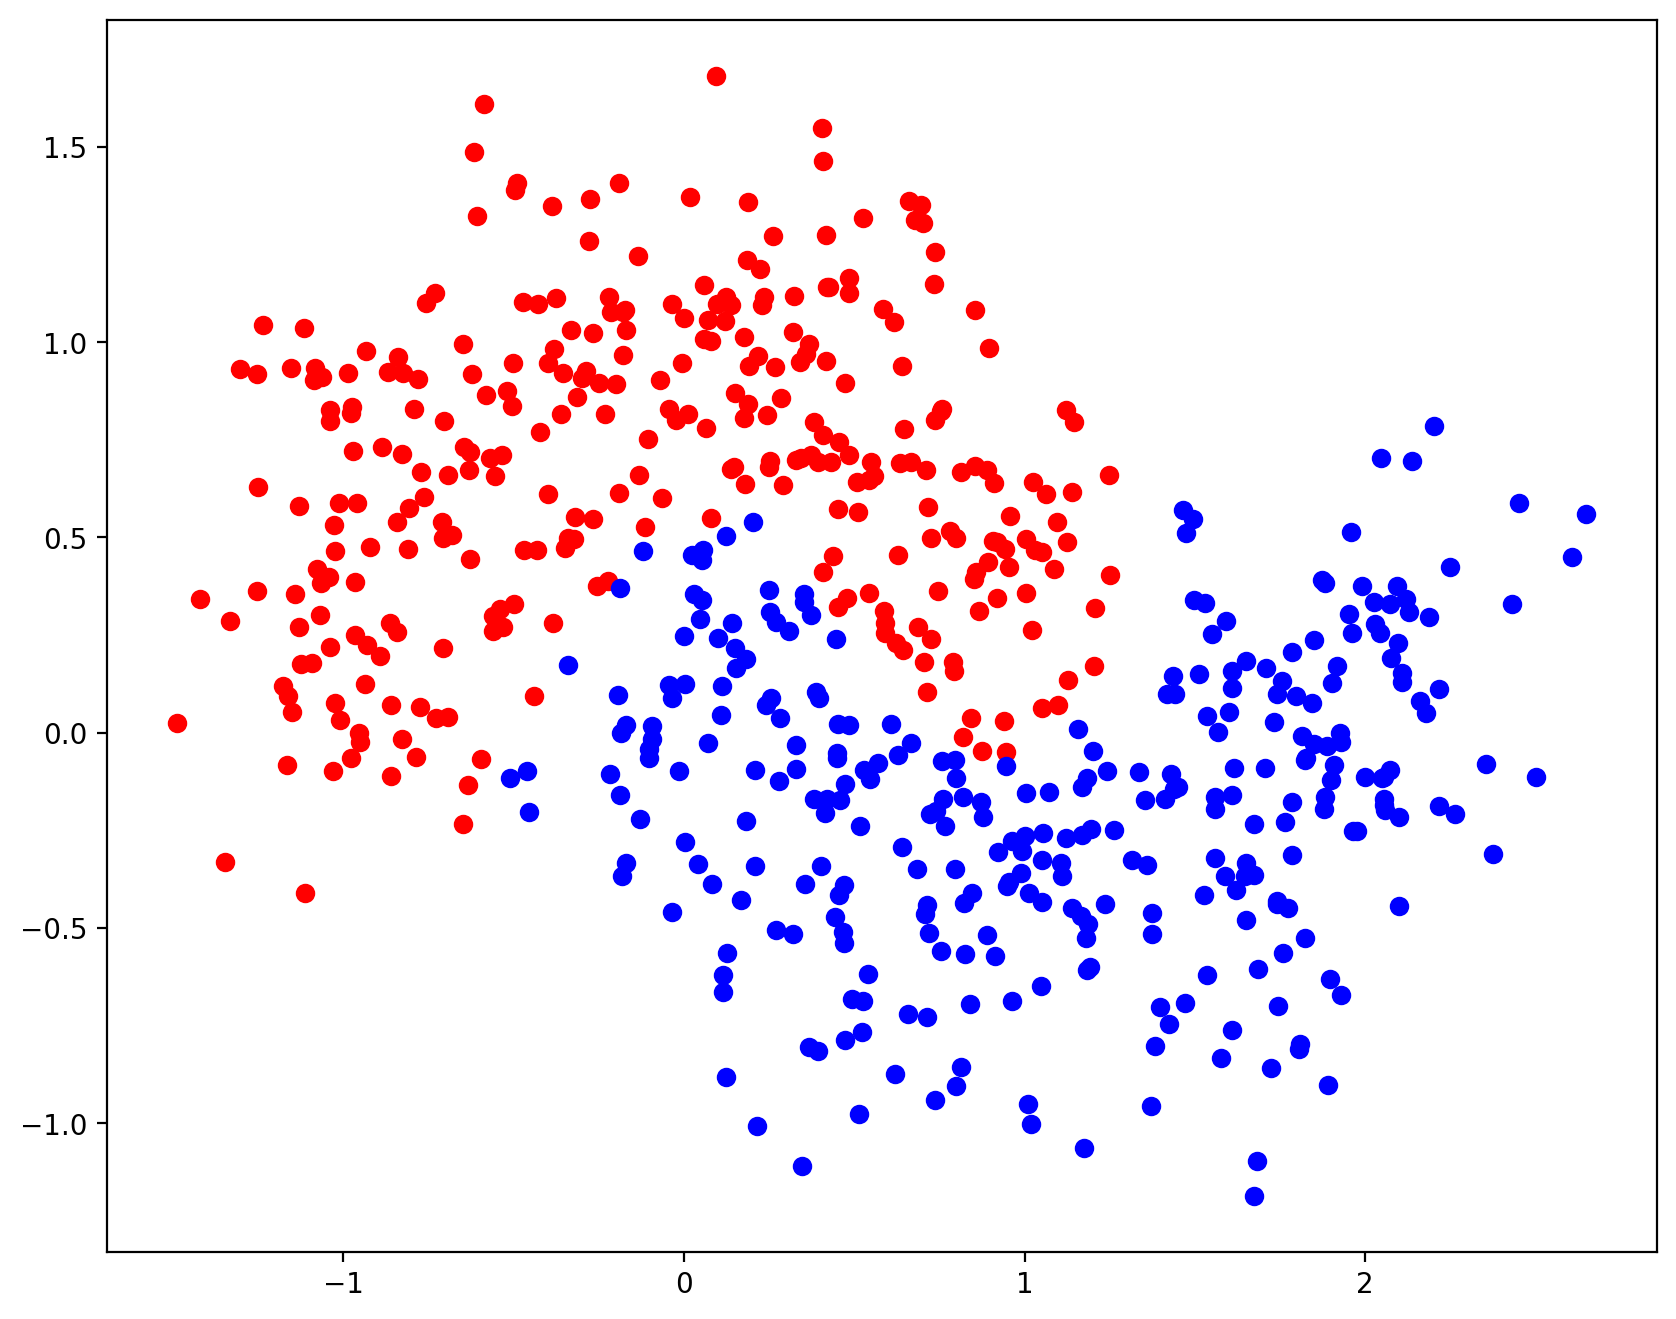

In [27]:
plt.scatter(Xs[Yh==0, 0][::subs], Xs[Yh==0, 1][::subs], c="r")
plt.scatter(Xs[Yh==1, 0][::subs], Xs[Yh==1, 1][::subs], c="b")
plt.show()

## Dummy task with very large data

In [37]:
X_big = np.random.randn(1000000, 200)  # 10 million samples

In [38]:
# outputs are sums of first 10 and second 10 input values
Y_big = np.stack((X_big[:, :10].sum(1), X_big[:, 10:20].sum(1))).T
Y_big.shape

(1000000, 2)

In [39]:
elm_cpu = hpelm.HPELM(200, 2)

# elm_gpu = hpelm.HPELM(200, 2, precision="single", accelerator="GPU")

In [40]:
elm_gpu = hpelm.HPELM(200, 2, precision="single")

In [41]:
elm_cpu.add_neurons(200, 'lin')
elm_cpu.add_neurons(1000, 'tanh')

elm_gpu.add_neurons(200, 'lin')
elm_gpu.add_neurons(1000, 'tanh')

In [42]:
%%time
elm_cpu.train(X_big, Y_big)

processing batch 107/1000, eta 0:00:41
processing batch 214/1000, eta 0:00:36
processing batch 321/1000, eta 0:00:31
processing batch 418/1000, eta 0:00:28
processing batch 523/1000, eta 0:00:22
processing batch 629/1000, eta 0:00:17
processing batch 736/1000, eta 0:00:12
processing batch 842/1000, eta 0:00:07
processing batch 948/1000, eta 0:00:02
CPU times: user 45 s, sys: 2.09 s, total: 47.1 s
Wall time: 47.7 s


In [43]:
%%time
elm_gpu.train(X_big, Y_big)

processing batch 143/1000, eta 0:00:29
processing batch 290/1000, eta 0:00:24
processing batch 435/1000, eta 0:00:19
processing batch 590/1000, eta 0:00:13
processing batch 744/1000, eta 0:00:08
processing batch 892/1000, eta 0:00:03
CPU times: user 31.1 s, sys: 2.16 s, total: 33.3 s
Wall time: 33.7 s


plots checking that output weights correctly correspond 
to sum of first 10 inputs and the next 10 inputs

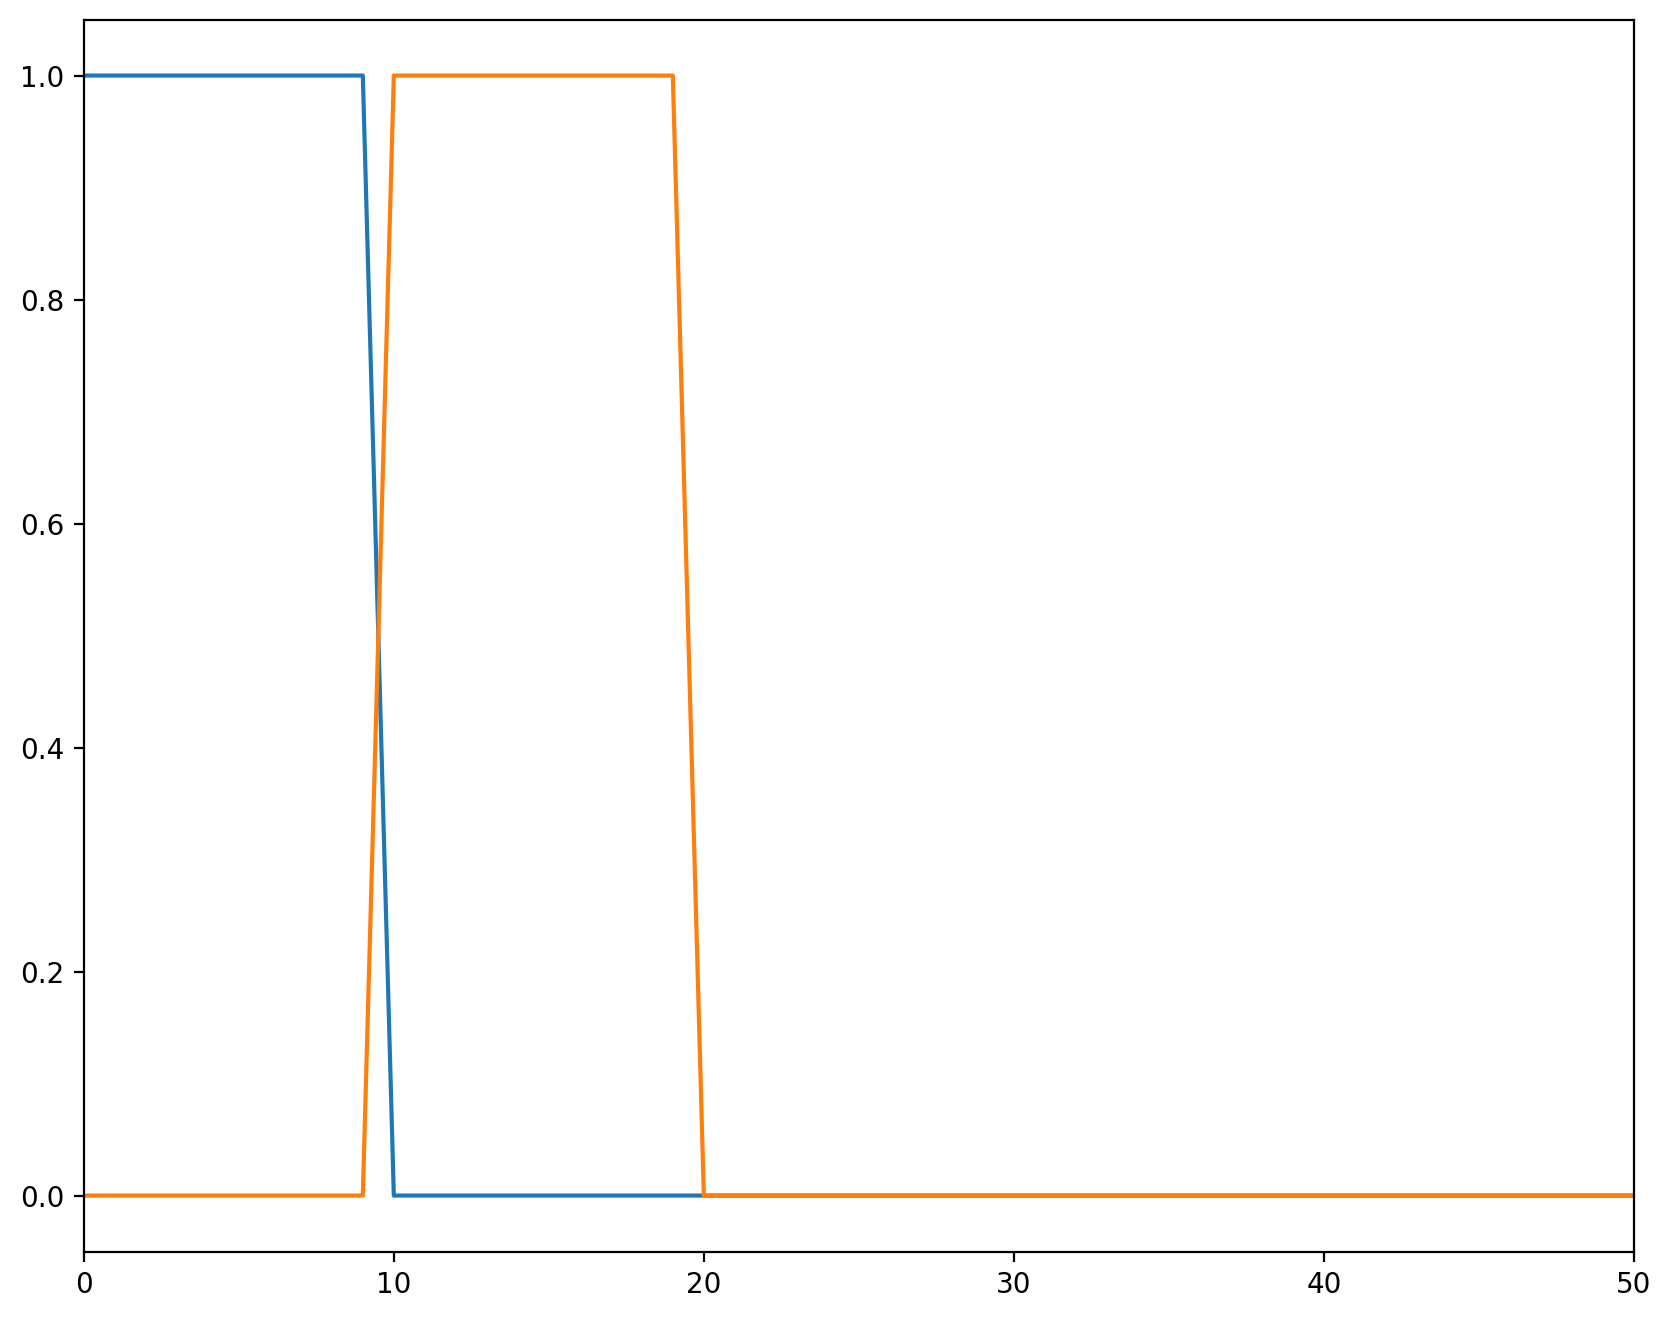

In [44]:
B_cpu = elm_cpu.nnet.get_B()
plt.plot(range(1200), B_cpu[:,0])
plt.plot(range(1200), B_cpu[:,1])
plt.xlim([0, 50])
plt.show()

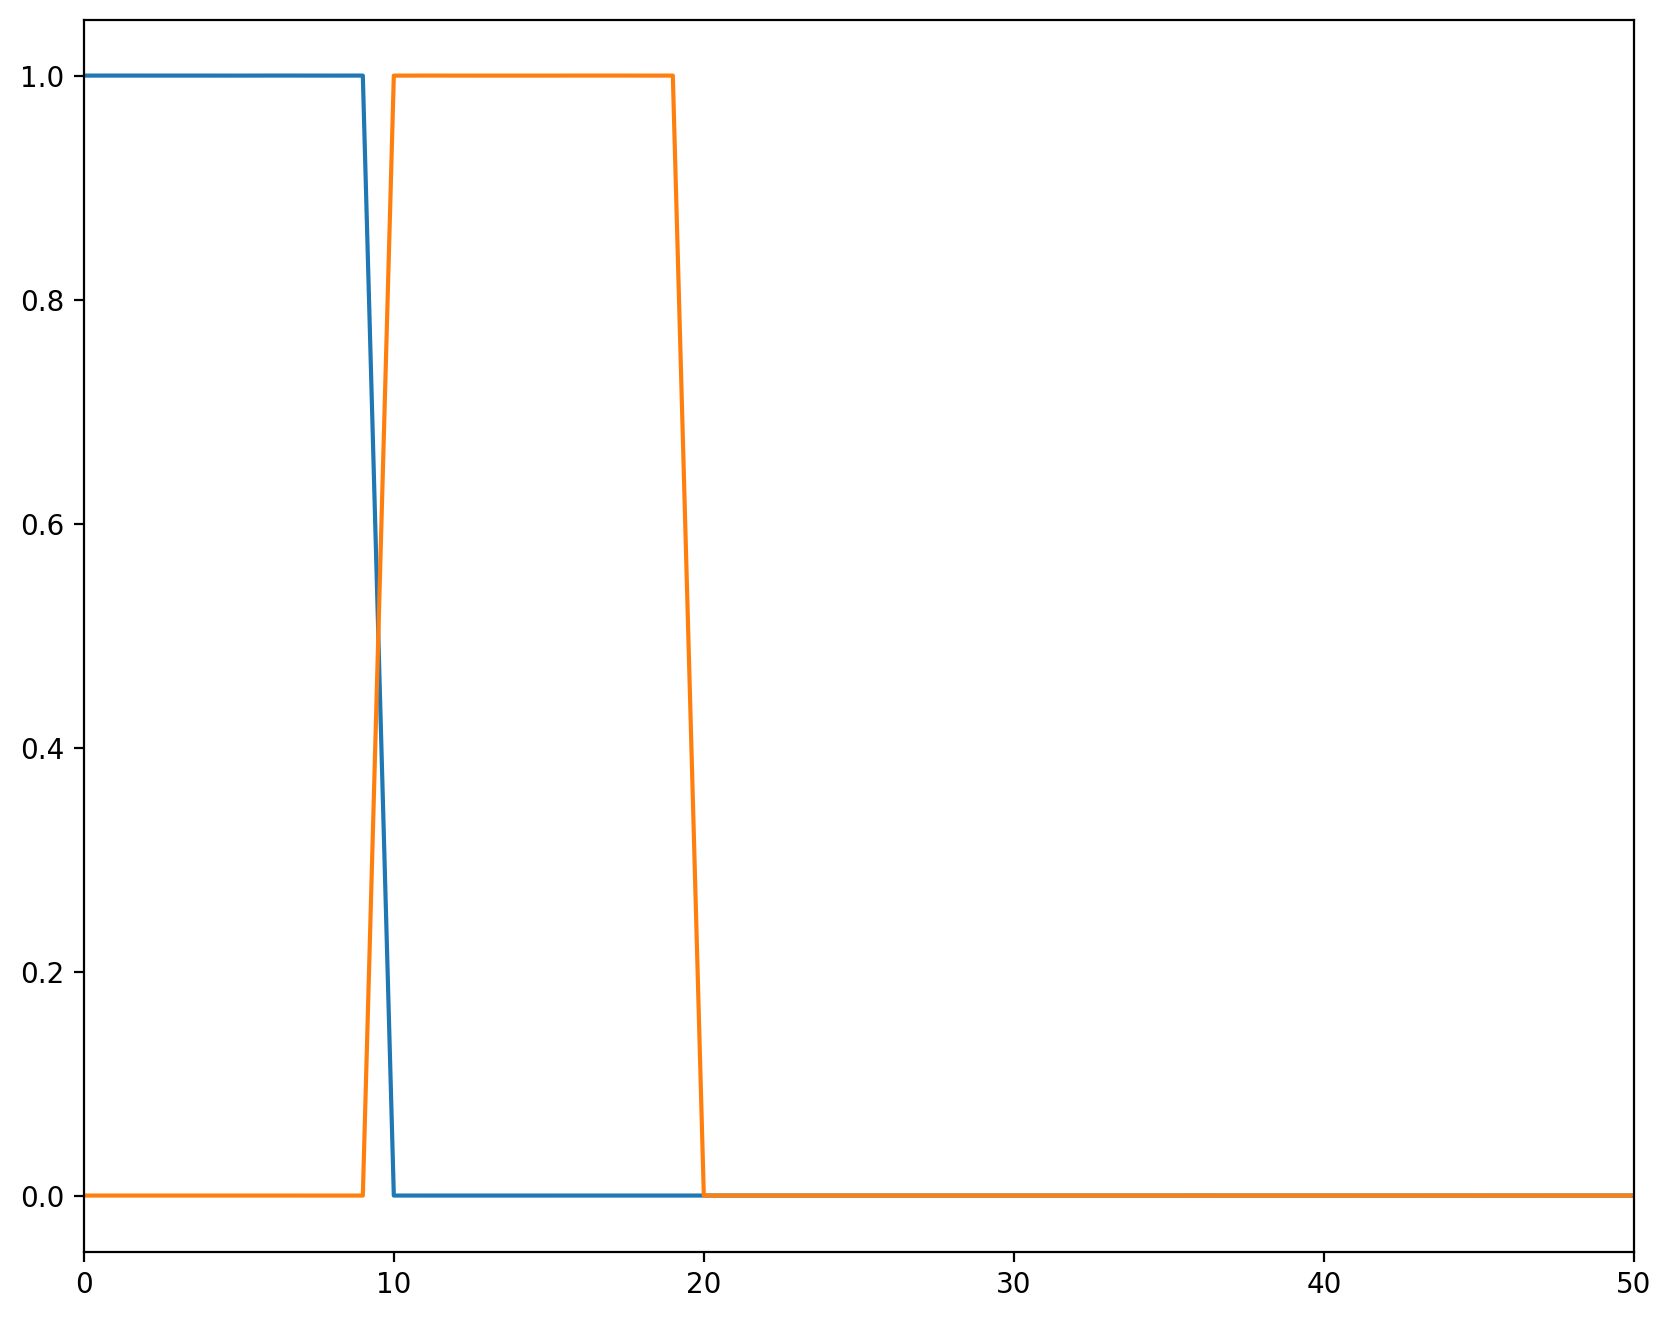

In [45]:
B_gpu = elm_gpu.nnet.get_B()  # this corectly downloads weights from GPU back to main memory
plt.plot(range(1200), B_gpu[:,0])
plt.plot(range(1200), B_gpu[:,1])
plt.xlim([0, 50])
plt.show()